# Load Libraries

In [1]:
import os
os.chdir("..")
from parc import model
from parc import IO
from parc import losses
from parc import graphs
import keras
import numpy as np

# Initialize Parameters

### Adaptable Input Data 

In [9]:
#initialize input data characteristics
data_dir = "C:\\Users\\Austin Leonard\\parc_data\\data\\raw"      #input data file directory
case_numbers = 2                        #number of cases
del_t = 0.79*(10**-9)                   #time step size
time_steps = 20                         #desired time steps for data processing
t_idx = del_t * np.arange(1,time_steps) #time index in seconds

### Adaptable Model Parameters 

In [3]:
#initialize adaptable model parameters
input_size = (None,None,2)
depth = 3
kernel_size = 5
numFeatureMaps = 128

#initialize loss parameters
weight_loss = [4,1,1] #initial timestep weights, middle weights, late weights

### Adaptable Post-Processing 

# Initialization

### Parse and Split Data 

In [15]:
import importlib

importlib.reload(IO)

<module 'parc.IO' from 'C:\\Users\\Austin Leonard\\parc\\parc\\IO.py'>

In [ ]:
#Parse the raw data and return microstructure data and temperature/pressure outputs
data_in, total_output, T_max, T_min, P_max, P_min = IO.parse_data(data_dir,time_steps,del_t)
## get data set for 10 timesteps
#data_in, total_output = IO.parse_data(data_dir,10,del_t)
## get data set for 20 timesteps
#data_in, total_output = IO.parse_data(data_dir,time_steps,del_t)

In [10]:
# split data set
X_train, y_train, X_val, y_val, test_X, test_Y = IO.split_data(data_in,total_output,splits=[0.6, 0.2, 0.2])

10
6
8
10
(6, 240, 240, 2)
(6, 240, 240, 20, 4)
(2, 240, 240, 2)
(2, 240, 240, 20, 4)
(2, 240, 240, 2)
(2, 240, 240, 20, 4)


### Prepare PARC

In [11]:
#initilize model parameters
parc_model = model.parc(input_size,time_steps,depth,kernel_size,numFeatureMaps)
loss = ["mse", "mse"] # double check with Phong on loss set up
loss_weights = [1, 1]
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["mae"]
parc_model.compile(loss = loss,loss_weights = loss_weights,optimizer = optimizer,metrics = metrics)

In [16]:
# {fields: 2, timestep: 19}
temp1 = model.parc(input_size,time_steps,depth,kernel_size,numFeatureMaps)
print( '{fields: 2, timestep: 19}' )
print( 'input:', temp1.input_shape )
print( 'output:', temp1.output_shape )

# {fields: 2, timestep: 10}
temp2 = model.parc(input_size,10,depth,kernel_size,numFeatureMaps)
print( 'input:', temp2.input_shape )
print( 'output:', temp2.output_shape )

# {fields: 1, timestep: 19}
# not implemented yet
# temp2 = model.parc(input_size,10,depth,kernel_size,numFeatureMaps)
# print( 'input:', temp2.input_shape )
# print( 'output:', temp2.output_shape )

{fields: 2, timestep: 19}
input: [(None, None, None, 2), (None, None, None, 2)]
output: [(None, None, None, 38), (None, None, None, 38)]


IndexError: list index out of range

# Training

### 5-Dimensional Format Training 

In [7]:
########for 5 dimensional data format############
#x_tn_init = y_train[:,:,:,0,:1]
#x_val_init = y_val[:,:,:,0,:1]

#train the model using training set 
#history = parc_model.fit(
#    x=[X_train, x_tn_init],
#    y=[y_train[:, :, :, 1:, :1], y_train[:, :, :, 1:, 2:3]],
#    validation_data=([X_val, x_val_init], [y_val[:, :, :, :, :1], y_val[:, :, :, :, 2:3]]),
#    batch_size=1,
#    epochs=2,
#)
################################################

### 4-Dimensional Format Training 

In [8]:
#####for 4 dimensional data format#######
#reshape to match old data format
y_train = IO.reshape_old(y_train)
y_val = IO.reshape_old(y_val)
test_Y = IO.reshape_old(test_Y)

x_tn_init = y_train[:,:,:,0:2]
x_val_init = y_val[:,:,:,0:2]
x_test_init = test_Y[:,:,:,0:2]

#train the model using training set, skip this part if already trained
#history = parc_model.fit(
#    x=[X_train, x_tn_init],
#    y=[y_train[:, :, :, 2:40], y_train[:, :, :, 40:]],
#    validation_data=([X_val, x_val_init], [y_val[:, :, :, 2:40], y_val[:, :, :, 40:]]),
#    batch_size=1,
#    epochs=2,
#)

Starting shape of data:  (1, 240, 240, 20, 4)
Reformatted data shape:  (1, 240, 240, 78)
Starting shape of data:  (0, 240, 240, 20, 4)
Reformatted data shape:  (0, 240, 240, 78)
Starting shape of data:  (1, 240, 240, 20, 4)
Reformatted data shape:  (1, 240, 240, 78)


In [9]:
#save trained model weights
parc_model.save_weights("../parc_data/PARC_trained_data.h5")

#load trained model weights
parc_model.load_weights("../parc_data/PARC_trained_data.h5")

# Prediction

In [10]:
#prediction using trained model parameters
pred = parc_model.predict([test_X,x_test_init])

#definition of temperature prediction and ground truth with rescaling
Temp_pred = pred[0][:,:,:,0::2]
Temp_pred = Temp_pred[:,:,:,:19]
Temp_pred = (Temp_pred+1.0)/2.0
Temp_gt = test_Y[:,:,:,0::2]
Temp_gt = Temp_gt[:,:,:,:19]
Temp_gt = (Temp_gt+1.0)/2.0

#definition of pressure prediction and ground truth with rescaling
Pres_pred = pred[0][:,:,:,1::2]
Pres_pred = Pres_pred[:,:,:,:19]
Pres_pred = (Pres_pred+1.0)/2.0
Pres_gt = test_Y[:,:,:,1::2]
Pres_gt = Pres_gt[:,:,:,:19]
Pres_gt = (Pres_gt+1.0)/2.0

1/1 [==============================] - 42s 42s/step


# Losses

In [11]:
#calculate root mean squared, r2 score, and losses
pred_cases = pred[0].shape[0]
rmse = losses.rmse(Temp_gt,Temp_pred,pred_cases,time_steps)
r2 = losses.r2(Temp_gt,Temp_pred,pred_cases,time_steps)
loss_cv = losses.step_weighted_loss(Temp_gt,Temp_pred, weight_loss)
#step_loss = losses.step_weighted_physical_loss(Temp_gt,Temp_pred,loss_cv)
state_loss = losses.state_weighted_loss(Temp_gt,Temp_pred)

temp loss:  tf.Tensor(
[[[0.44278486 0.77437614 1.31281059 ... 2.24261518 2.01639502 0.46672471]
  [0.80331557 1.23534935 2.03419608 ... 2.49578016 1.51186942 0.13629391]
  [1.36577507 1.4390729  1.37838706 ... 2.3527859  2.42306745 0.8673408 ]
  ...
  [0.91801415 2.41977712 2.24032685 ... 2.49726814 2.0793576  1.39918988]
  [0.87445688 1.55601615 2.04675816 ... 1.66790869 0.85821149 0.61633216]
  [0.73114978 1.13250639 1.51542891 ... 0.30906509 0.13071149 0.073608  ]]], shape=(1, 240, 240), dtype=float64)
pressure loss:  tf.Tensor(
[[[ 3.45637561  8.06441055 14.64417004 ... 20.24326573 16.75440099
    3.93143543]
  [ 8.84950436 14.56028838 23.40271154 ... 24.45660906 13.55180341
    2.09856302]
  [14.95096264 15.19413072 16.01412345 ... 23.85405288 21.22346192
    7.27700914]
  ...
  [13.12715848 30.49647021 29.53397847 ... 25.36934612 19.78100081
   14.32166512]
  [11.41322476 17.28758678 23.03086484 ... 18.03953761  8.20535348
    6.20456014]
  [ 8.8974135  12.48177933 16.44489257 .

# Graphs

In [12]:
#reshape to match new data format
test_Y = IO.reshape_new(test_Y)
pred[0] = IO.reshape_new(pred[0],2)
pred[0][:,:,:,0,0] = test_Y[:,:,:,0,0]
pred[0][:,:,:,0,1] = test_Y[:,:,:,0,1]

Starting shape of data:  (1, 240, 240, 78)
Reformatted data shape:  (1, 240, 240, 20, 4)
Starting shape of data:  (1, 240, 240, 38)
Reformatted data shape:  (1, 240, 240, 20, 2)


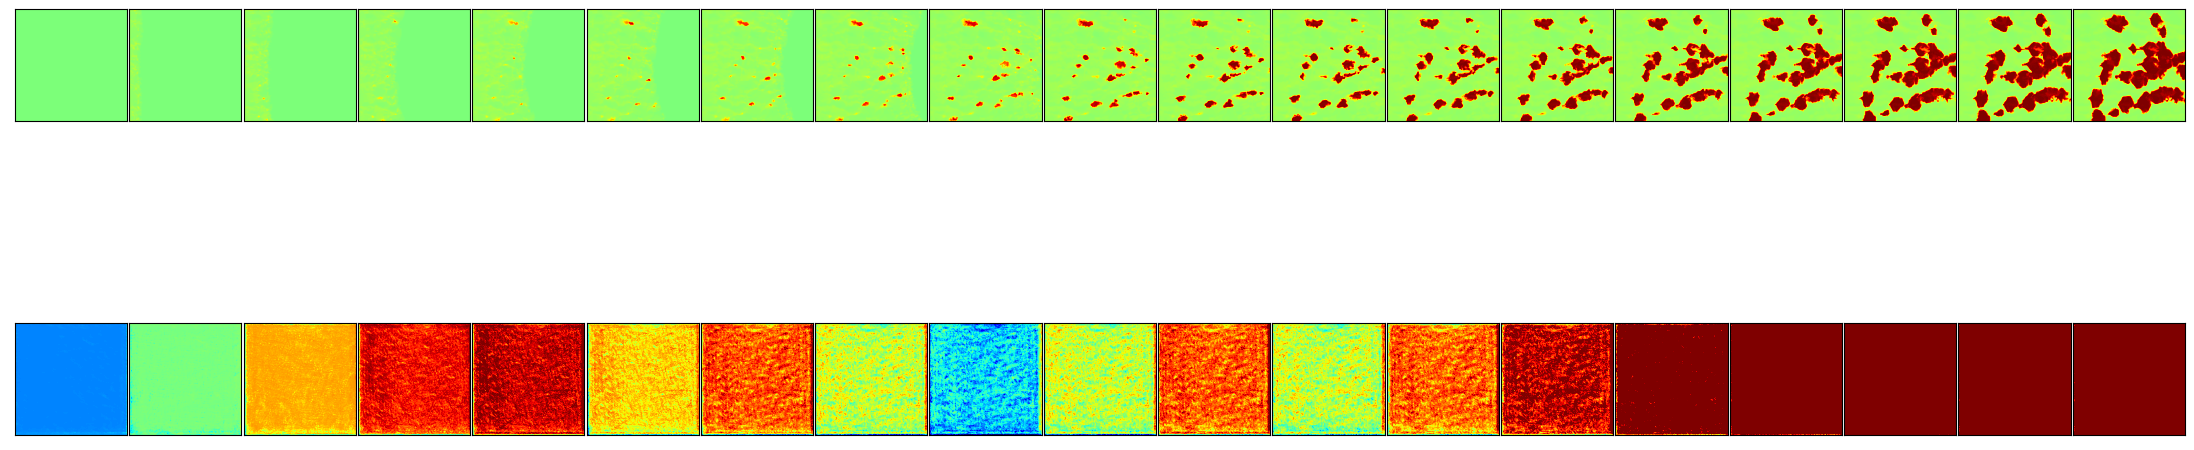

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


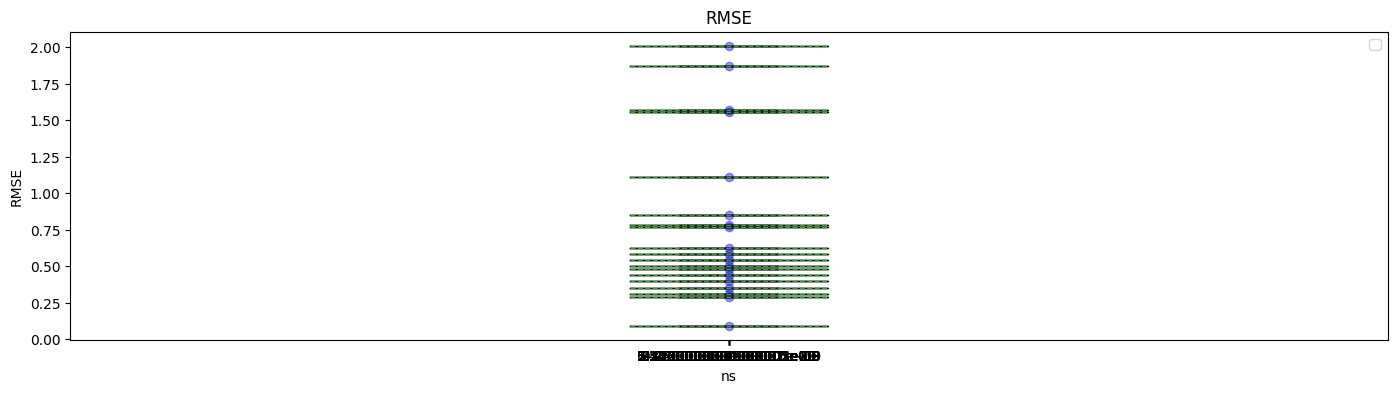

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


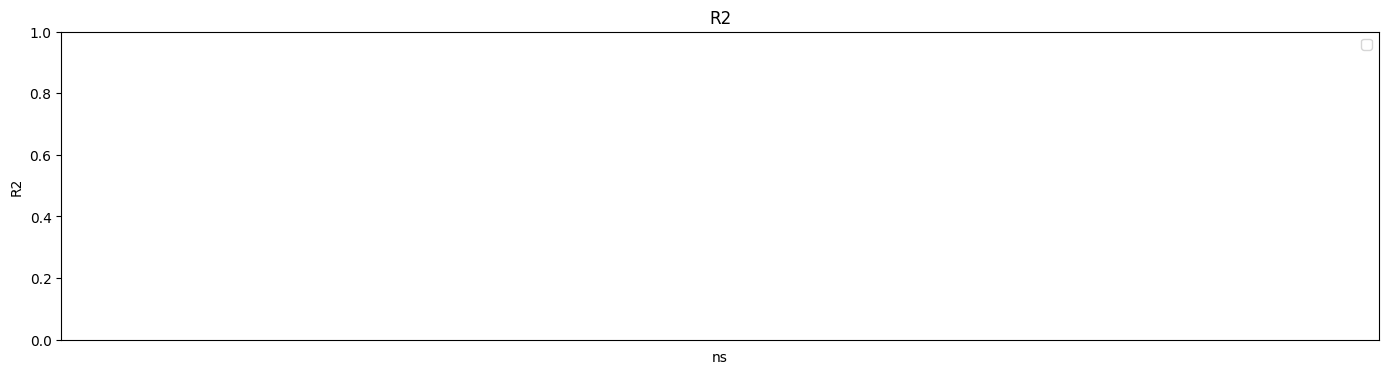

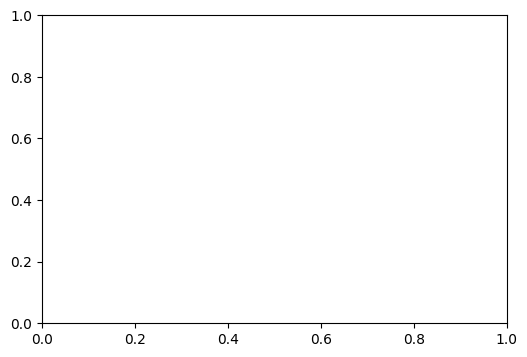

In [73]:
#create plots for data
graphs.visualize_inference(Temp_gt,Temp_pred,t_idx,0)
graphs.plot_rmse(rmse,t_idx)
graphs.plot_r2(r2,t_idx)
#graphs.plot_sensitivity_area(Temp_gt,Temp_pred,t_idx,Temp_pred.shape[0])
#graphs.plot_sensitivity_temperature(Temp_gt,Temp_pred,t_idx,Temp_pred.shape[0])
graphs.plot_saliency(Temp_pred,5)

In [72]:
import importlib

importlib.reload(graphs)

<module 'parc.graphs' from 'C:\\Users\\Austin Leonard\\parc\\parc\\graphs.py'>